# Explore here

In [1]:
# BLOQUE 01
# SETUP DEL PROYECTO (RUTAS + SEMILLA)
# - Definimos estructura minima (data/raw, data/processed, models, reports)
# - Garantizamos reproducibilidad (random_state fijo)
# - Dejamos todo listo para correr de principio a fin

from pathlib import Path

RANDOM_STATE = 42

BASE_DIR = Path(".")
DIRS = [
    BASE_DIR / "data" / "raw",
    BASE_DIR / "data" / "processed",
    BASE_DIR / "models",
    BASE_DIR / "reports",
]

for d in DIRS:
    d.mkdir(parents=True, exist_ok=True)

print("OK - folders created:", [str(d) for d in DIRS])
print("OK - RANDOM_STATE =", RANDOM_STATE)

# Resultado esperado:
# - Carpetas creadas sin errores
# - Se muestra RANDOM_STATE=42

# Interpretación:
# - Proyecto reproducible y organizado
# - Facilita entregar y versionar el modelo


OK - folders created: ['data/raw', 'data/processed', 'models', 'reports']
OK - RANDOM_STATE = 42


In [2]:
# BLOQUE 02
# CARGA DEL DATASET (LOCAL O URL)
# - Cargamos diabetes.csv si existe localmente
# - Si no existe, lo descargamos desde el link del proyecto
# - Guardamos una copia en data/raw/

import pandas as pd
from pathlib import Path

local_csv = Path("diabetes.csv")
raw_csv = Path("data/raw/diabetes.csv")
url = "https://breathecode.herokuapp.com/asset/internal-link?id=421&path=diabetes.csv"

if local_csv.exists():
    df = pd.read_csv(local_csv)
    df.to_csv(raw_csv, index=False)
else:
    df = pd.read_csv(url)
    df.to_csv(raw_csv, index=False)

print("OK - shape:", df.shape)
print("OK - saved to:", raw_csv)
df.head()

# Resultado esperado:
# - Dataset cargado con ~768 filas y 9 columnas
# - Archivo guardado en data/raw/diabetes.csv

# Interpretación:
# - Ya tenemos la fuente del proyecto
# - Podemos auditar cambios desde data/raw


OK - shape: (768, 9)
OK - saved to: data/raw/diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# BLOQUE 03
# INSPECCION RAPIDA (TIPOS + NULOS + DUPLICADOS)
# - Revisamos tipos de datos y valores nulos
# - Detectamos duplicados para limpiar el dataset
# - Esto evita ruido en el entrenamiento

print(df.info())
print("\nNULLs per column:\n", df.isna().sum())

dup_count = df.duplicated().sum()
print("\nDuplicated rows:", dup_count)

if dup_count > 0:
    df = df.drop_duplicates().reset_index(drop=True)

print("OK - shape after drop_duplicates:", df.shape)

# Resultado esperado:
# - Pocos o cero nulos (depende del archivo)
# - Duplicados eliminados si existian

# Interpretación:
# - Evitamos inflar metricas por filas repetidas
# - Base mas confiable para EDA y modelado


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None

NULLs per column:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age  

Counts:
 Outcome
0    500
1    268
Name: count, dtype: int64

Ratios:
 Outcome
0    0.651
1    0.349
Name: count, dtype: float64


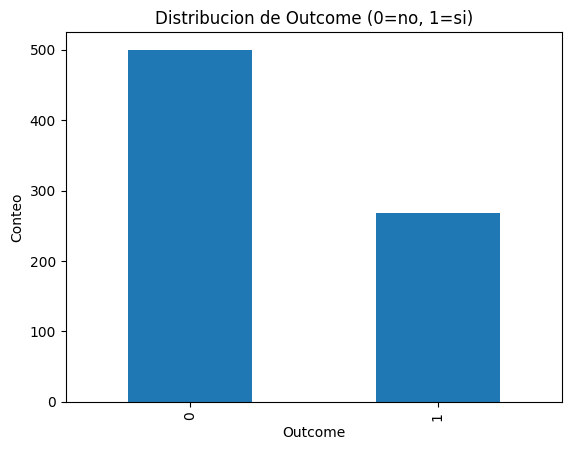

In [4]:
# BLOQUE 04
# EDA: DISTRIBUCION DEL TARGET (OUTCOME)
# - Verificamos balance de clases
# - Esto define si usamos metricas mas alla de accuracy
# - Guardamos esta referencia mental para evaluacion

import matplotlib.pyplot as plt

target_col = "Outcome"
target_counts = df[target_col].value_counts().sort_index()
target_ratio = (target_counts / target_counts.sum()).round(3)

print("Counts:\n", target_counts)
print("\nRatios:\n", target_ratio)

ax = target_counts.plot(kind="bar")
ax.set_title("Distribucion de Outcome (0=no, 1=si)")
ax.set_xlabel("Outcome")
ax.set_ylabel("Conteo")
plt.show()

# Resultado esperado:
# - Barra con 0 mas frecuente que 1 (normalmente)
# - Se imprimen conteos y proporciones

# Interpretación:
# - Si hay desbalance, accuracy sola puede enganar
# - Metricas como recall/F1 seran clave


In [5]:
# BLOQUE 05
# EDA: ESTADISTICAS + CEROS SOSPECHOSOS
# - En este dataset, ciertos 0 suelen significar dato faltante
# - Revisamos columnas donde 0 no tiene sentido clinico
# - Luego decidimos imputacion/limpieza

import numpy as np

feature_cols = [c for c in df.columns if c != target_col]

print(df[feature_cols].describe().T)

# Columns where 0 is often a missing-value proxy in this dataset
zero_as_missing_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

zero_report = {}
for c in zero_as_missing_cols:
    if c in df.columns:
        zero_report[c] = int((df[c] == 0).sum())

print("\nZeros potentially-missing:\n", zero_report)

# Resultado esperado:
# - Tabla describe() por variable
# - Conteo de ceros raros en variables clinicas

# Interpretación:
# - Si dejamos ceros falsos, el arbol aprende patrones incorrectos
# - Imputar mejora senal y generalizacion


                          count        mean         std     min       25%  \
Pregnancies               768.0    3.845052    3.369578   0.000   1.00000   
Glucose                   768.0  120.894531   31.972618   0.000  99.00000   
BloodPressure             768.0   69.105469   19.355807   0.000  62.00000   
SkinThickness             768.0   20.536458   15.952218   0.000   0.00000   
Insulin                   768.0   79.799479  115.244002   0.000   0.00000   
BMI                       768.0   31.992578    7.884160   0.000  27.30000   
DiabetesPedigreeFunction  768.0    0.471876    0.331329   0.078   0.24375   
Age                       768.0   33.240885   11.760232  21.000  24.00000   

                               50%        75%     max  
Pregnancies                 3.0000    6.00000   17.00  
Glucose                   117.0000  140.25000  199.00  
BloodPressure              72.0000   80.00000  122.00  
SkinThickness              23.0000   32.00000   99.00  
Insulin                   

In [6]:
# BLOQUE 06
# LIMPIEZA: REEMPLAZAR 0->NaN + IMPUTACION MEDIANA
# - Convertimos ceros sospechosos a NaN
# - Imputamos con mediana (robusta a outliers)
# - Guardamos dataset procesado

import pandas as pd
from pathlib import Path

df_clean = df.copy()

for c in zero_as_missing_cols:
    if c in df_clean.columns:
        df_clean[c] = df_clean[c].replace(0, np.nan)

# Median imputation
medians = df_clean[feature_cols].median(numeric_only=True)
df_clean[feature_cols] = df_clean[feature_cols].fillna(medians)

processed_csv = Path("data/processed/diabetes_processed.csv")
df_clean.to_csv(processed_csv, index=False)

print("OK - saved:", processed_csv)
print("Remaining NULLs:", int(df_clean.isna().sum().sum()))
df_clean.head()

# Resultado esperado:
# - Dataset sin nulos
# - Archivo guardado en data/processed/diabetes_processed.csv

# Interpretación:
# - Datos clinicos mas realistas
# - Menos ruido -> arbol mas estable


OK - saved: data/processed/diabetes_processed.csv
Remaining NULLs: 0


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,125.0,33.6,0.627,50,1
1,1,85.0,66.0,29.0,125.0,26.6,0.351,31,0
2,8,183.0,64.0,29.0,125.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [7]:
# BLOQUE 07
# SPLIT TRAIN/TEST (ESTRATIFICADO)
# - Dividimos manteniendo proporcion del target
# - Evitamos fuga de informacion
# - Base estandar para comparar modelos

from sklearn.model_selection import train_test_split

X = df_clean.drop(columns=[target_col])
y = df_clean[target_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Outcome ratio train:", (y_train.value_counts(normalize=True).sort_index().round(3)).to_dict())
print("Outcome ratio test :", (y_test.value_counts(normalize=True).sort_index().round(3)).to_dict())

# Resultado esperado:
# - Split 80/20
# - Proporciones de Outcome similares en train y test

# Interpretación:
# - Evaluacion justa
# - Comparaciones entre modelos son validas


Train: (614, 8) Test: (154, 8)
Outcome ratio train: {0: 0.651, 1: 0.349}
Outcome ratio test : {0: 0.649, 1: 0.351}


In [8]:
# BLOQUE 08
# MODELOS BASE: ARBOL CON CRITERIOS (GINI / ENTROPY / LOG_LOSS)
# - Entrenamos variantes cambiando criterio de pureza
# - Medimos con metricas de clasificacion (no solo accuracy)
# - Elegimos el mejor criterio por F1 (y/o ROC-AUC)

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

criteria = ["gini", "entropy", "log_loss"]
rows = []

for crit in criteria:
    try:
        clf = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion=crit)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

        rows.append(
            {
                "criterion": crit,
                "accuracy": accuracy_score(y_test, y_pred),
                "precision": precision_score(y_test, y_pred, zero_division=0),
                "recall": recall_score(y_test, y_pred, zero_division=0),
                "f1": f1_score(y_test, y_pred, zero_division=0),
                "roc_auc": roc_auc_score(y_test, y_proba) if y_proba is not None else float("nan"),
            }
        )
    except Exception as e:
        rows.append({"criterion": crit, "error": str(e)})

results_crit = pd.DataFrame(rows)
results_crit

# Resultado esperado:
# - Tabla con metricas por criterio
# - Un criterio destaca en F1/ROC-AUC

# Interpretación:
# - Elegimos el criterio que mejor separa diabeticos vs no diabeticos
# - En medicina suele importar mas recall de la clase positiva


,criterion,accuracy,precision,recall,f1,roc_auc
0,gini,0.681818,0.553191,0.481481,0.514851,0.635741
1,entropy,0.675325,0.538462,0.518519,0.528302,0.639259
2,log_loss,0.675325,0.538462,0.518519,0.528302,0.639259


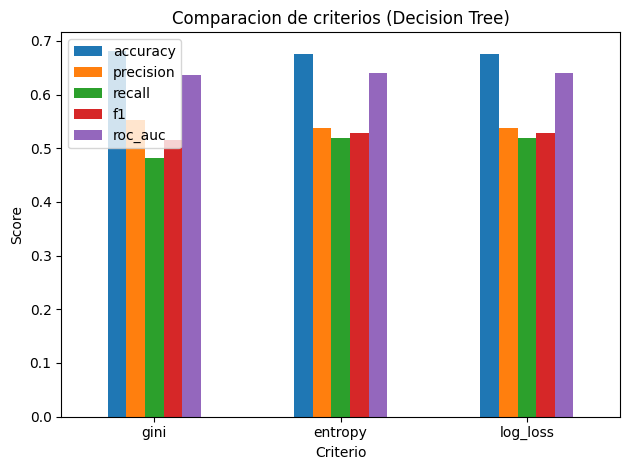

BEST_CRITERION_BY_F1 = entropy


In [9]:
# BLOQUE 09
# GRAFICO COMPARATIVO DE CRITERIOS
# - Visualizamos metricas clave por criterio
# - Identificamos trade-offs (precision vs recall)
# - Esto guia la optimizacion

import matplotlib.pyplot as plt

plot_df = results_crit.drop(columns=["error"], errors="ignore").copy()
plot_df = plot_df.dropna(subset=["f1"])

metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]
plot_df = plot_df.set_index("criterion")[metrics]

ax = plot_df.plot(kind="bar", rot=0)
ax.set_title("Comparacion de criterios (Decision Tree)")
ax.set_xlabel("Criterio")
ax.set_ylabel("Score")
plt.tight_layout()
plt.show()

best_criterion = plot_df["f1"].idxmax()
print("BEST_CRITERION_BY_F1 =", best_criterion)

# Resultado esperado:
# - Barras comparando metricas
# - Se imprime BEST_CRITERION_BY_F1

# Interpretación:
# - Baseline: criterio elegido con evidencia
# - Proximo paso: ajustar hiperparametros para generalizar


In [10]:
# BLOQUE 10
# GRID SEARCH: OPTIMIZACION DEL ARBOL
# - Optimizamos hiperparametros del mejor criterio
# - Usamos CV y scoring F1 para priorizar clase positiva
# - Guardamos el mejor estimador

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

base = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion=best_criterion)

param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 8, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": [None, "sqrt", "log2"],
}

grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1,
    verbose=0,
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
print("OK - best params:", grid.best_params_)
print("OK - best cv f1:", grid.best_score_)

# Resultado esperado:
# - Se imprimen mejores hiperparametros
# - Best CV F1 > baseline (idealmente)

# Interpretación:
# - Arbol menos sobreajustado
# - Mejor equilibrio para detectar casos positivos


OK - best params: {'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2}
OK - best cv f1: 0.6407693616194018


{'accuracy': 0.7402597402597403, 'precision': 0.6666666666666666, 'recall': 0.5185185185185185, 'f1': 0.5833333333333334, 'roc_auc': 0.8237962962962964}

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.86      0.81       100
           1       0.67      0.52      0.58        54

    accuracy                           0.74       154
   macro avg       0.72      0.69      0.70       154
weighted avg       0.73      0.74      0.73       154



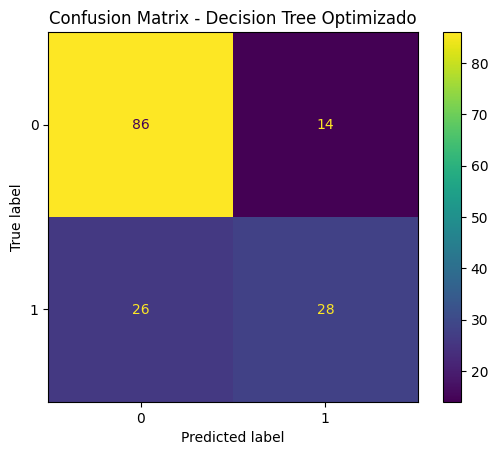

In [11]:
# BLOQUE 11
# EVALUACION FINAL (TEST): METRICAS + MATRIZ CONFUSION
# - Medimos el modelo optimizado en test (realidad)
# - Mostramos confusion matrix para entender errores
# - Decidimos si el modelo sirve para negocio/riesgo

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred_opt = best_model.predict(X_test)
y_proba_opt = best_model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_opt)
prec = precision_score(y_test, y_pred_opt, zero_division=0)
rec = recall_score(y_test, y_pred_opt, zero_division=0)
f1 = f1_score(y_test, y_pred_opt, zero_division=0)
auc = roc_auc_score(y_test, y_proba_opt)

print({"accuracy": acc, "precision": prec, "recall": rec, "f1": f1, "roc_auc": auc})
print("\nClassification report:\n", classification_report(y_test, y_pred_opt, zero_division=0))

cm = confusion_matrix(y_test, y_pred_opt)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Decision Tree Optimizado")
plt.show()

# Resultado esperado:
# - Metricas finales impresas (test)
# - Matriz confusion visible

# Interpretación:
# - FP = falsas alarmas (coste operativo)
# - FN = diabeticos no detectados (coste medico/negocio alto)


Glucose                     0.495919
BMI                         0.173132
DiabetesPedigreeFunction    0.082684
Age                         0.079453
Pregnancies                 0.051085
BloodPressure               0.043188
Insulin                     0.043179
SkinThickness               0.031359
dtype: float64


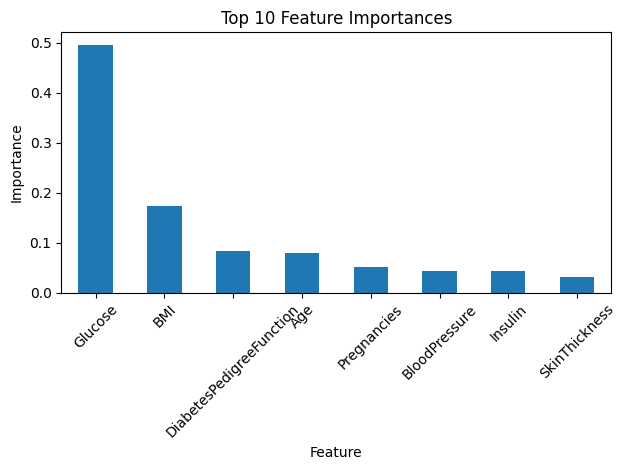

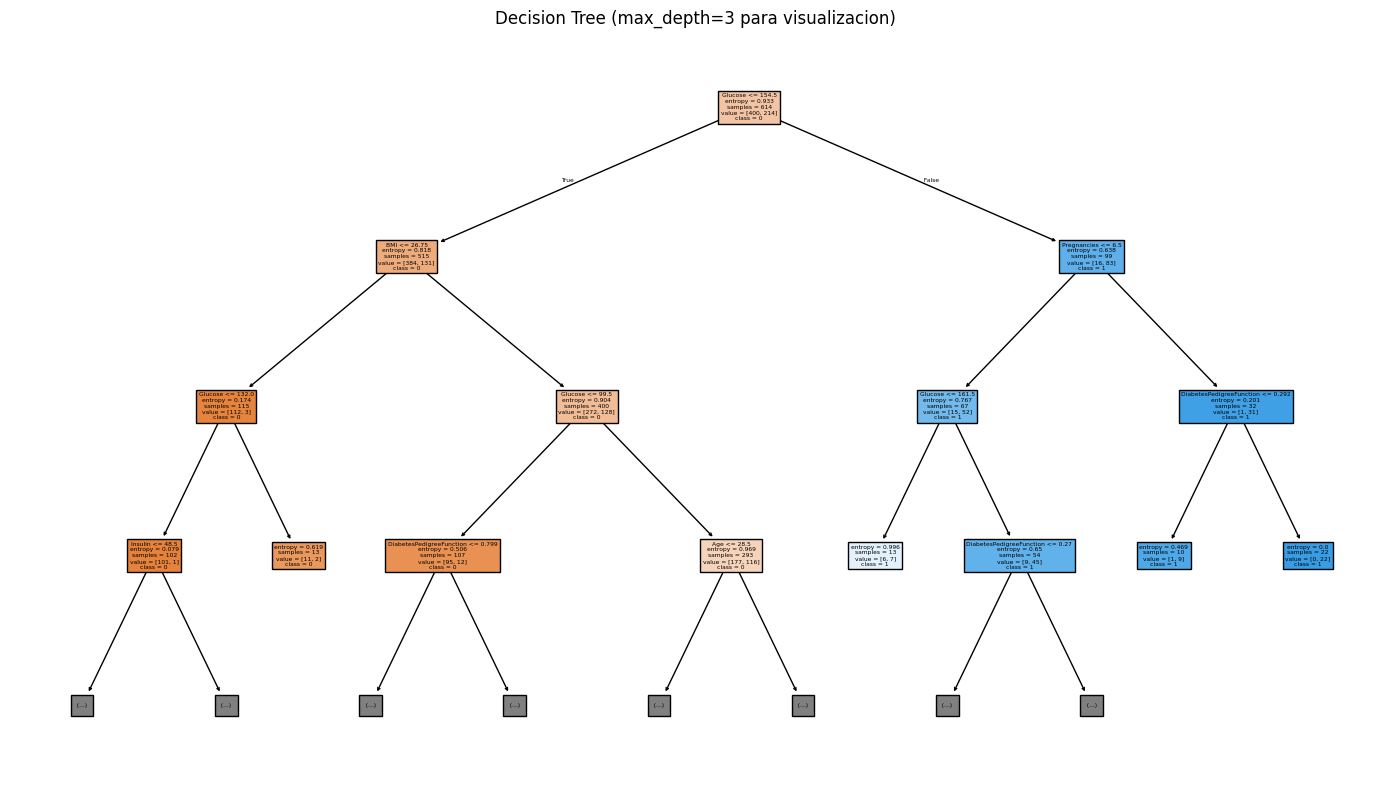

In [12]:
# BLOQUE 12
# INTERPRETABILIDAD: FEATURE IMPORTANCES + ARBOL (LIMITADO)
# - Mostramos variables mas influyentes
# - Graficamos el arbol con profundidad limitada (legible)
# - Esto permite explicar el modelo a stakeholders

import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree

importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(10))

ax = importances.head(10).plot(kind="bar", rot=45)
ax.set_title("Top 10 Feature Importances")
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(14, 8))
tree.plot_tree(
    best_model,
    feature_names=list(X.columns),
    class_names=["0", "1"],
    filled=True,
    max_depth=3,
)
plt.title("Decision Tree (max_depth=3 para visualizacion)")
plt.tight_layout()
plt.show()

# Resultado esperado:
# - Top features impresas (ej: Glucose, BMI, Age, etc.)
# - Arbol visible y entendible

# Interpretación:
# - Podemos justificar decisiones del modelo
# - Transparencia util para salud y compliance


In [13]:
# BLOQUE 13
# GUARDADO DEL MODELO + METADATA
# - Guardamos modelo optimizado en models/
# - Guardamos metadata (params + columnas)
# - Esto permite cargar y predecir en produccion

import json
from pathlib import Path
import joblib

model_path = Path("models/decision_tree_diabetes.joblib")
meta_path = Path("models/decision_tree_diabetes.metadata.json")

joblib.dump(best_model, model_path)

metadata = {
    "model_type": "DecisionTreeClassifier",
    "best_params": best_model.get_params(),
    "random_state": RANDOM_STATE,
    "features": list(X.columns),
    "target": target_col,
    "preprocessing": {
        "zero_as_missing_cols": zero_as_missing_cols,
        "imputation": "median",
    },
}

with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=2)

print("OK - model saved:", model_path)
print("OK - metadata saved:", meta_path)

# Resultado esperado:
# - Archivo .joblib en models/
# - Archivo .json con configuracion y features

# Interpretación:
# - Modelo reutilizable sin re-entrenar
# - Metadata evita olvidar como se prepararon los datos
# Se presentaron problemas con el filesystem de mi macos pero creo que fueron solventados


OK - model saved: models/decision_tree_diabetes.joblib
OK - metadata saved: models/decision_tree_diabetes.metadata.json
